<a href="https://colab.research.google.com/github/ahliminha/P300/blob/master/P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install mat4py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
from keras.utils import to_categorical
np.random.seed(816)

Using TensorFlow backend.


In [0]:
import glob

In [0]:
folder = '/content/drive/My Drive/IC/*.mat'
files = glob.glob(folder)
files.pop(0) #drop the data badly structured
test_file = files.pop(0) #last subject for testing the network

In [6]:
print(files)

['/content/drive/My Drive/IC/P300S03.mat', '/content/drive/My Drive/IC/P300S04.mat', '/content/drive/My Drive/IC/P300S05.mat', '/content/drive/My Drive/IC/P300S06.mat', '/content/drive/My Drive/IC/P300S07.mat', '/content/drive/My Drive/IC/P300S08.mat']


In [0]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [0]:
def prepare_data(file):
  allX = []
  allY = []
  allT = []
  allF = []
  raw_data = loadmat(file)
  useful_data = raw_data['data'].copy()
  X = useful_data['X']
  Y = useful_data['y']
  T = useful_data['trial']
  F = useful_data['flash']
  X_mean = np.mean(X, axis=1)
  X_filtered = butter_lowpass_filter(X_mean, cutoff, fs, order)
  
  return X_filtered, Y, T, F

In [0]:
def normalized(vec):
  norm_vec = (vec - vec.min(axis=1, keepdims=True))/vec.ptp(axis=1, keepdims=True)
  return norm_vec

In [0]:
def clean_data(X, Y, flash):
  
  X_samples = np.array([np.array(X[i[0]:i[0]+300]) for i in flash] )
  column    = [i[2] for i in flash]
  label     = [i[3] - 1 for i in flash]
  
  LIMIT = 4080 #the last trial is incomplete
  X_selected = np.array(X_samples[:LIMIT])
  col_selected = np.array(column[:LIMIT])
  label_selected = np.array(label[:LIMIT])

  y = np.array(to_categorical(label_selected))

  false_idx = [k for k, i in enumerate(y) if i[0] == 1]
  true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

  falseX = X_selected[false_idx]
  falsey = y[false_idx]

  trueX  = X_selected[true_idx]  
  truey  = y[true_idx]
  # proportional data to avoid greedy cost funtion

  proportionalX = falseX[:int(len(trueX))]
  proportionaly = falsey[:int(len(truey))]

  finalX = np.concatenate((trueX, proportionalX))
  finaly = np.concatenate((truey, proportionaly))

  X_timeseries = np.vstack(finalX)
  X_letters = X_timeseries.reshape(34,40,300,1)
  y_letters = finaly.reshape(34,40,2)
  cleaned_X = np.vstack(X_letters)
  cleaned_Y = np.vstack(y_letters)
  
  return cleaned_X, cleaned_Y

In [12]:
import tensorflow as tf

from tensorflow import keras
tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras import layers

input_layer = keras.Input(shape = (300,1), name='main_input')
#lstm  = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
#lstm1 = lstm(input_layer)
x     = layers.Conv1D(16, 3, activation='relu')(input_layer)
x     = layers.Conv1D(8, 3, activation='relu')(x)
x     = layers.GlobalAveragePooling1D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(4)(x)
output = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 300, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 16)           64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 8)            392       
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10    

In [0]:
#compiling the model
opt = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.9, amsgrad=True)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [0]:
from sklearn.model_selection import train_test_split
for file in files:
  X, Y, Trials, Flash = prepare_data(file)
  X_clean, y_clean = clean_data(X, Y, Flash)
  X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
  history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=20, epochs=20, verbose=0)
  

In [17]:
X, Y, Trials, Flash = prepare_data(test_file)
X_clean, y_clean = clean_data(X, Y, Flash)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
pred = model.fit(X_train, y_train, batch_size=10, epochs=20)

Epoch 1/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5123
Epoch 2/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5752
Epoch 3/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.5940
Epoch 4/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.5899
Epoch 5/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6176
Epoch 6/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.5940
Epoch 7/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6250
Epoch 8/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6127
Epoch 9/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6087
Epoch 10/20
123/123 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6250

In [18]:
score = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.7713 - accuracy: 0.5221


In [0]:
preds = model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

In [0]:
matrix_norm = np.zeros((2,2))
for i in range(2):
  matrix_norm[i] = matrix[i]/matrix[i].sum(axis=0)

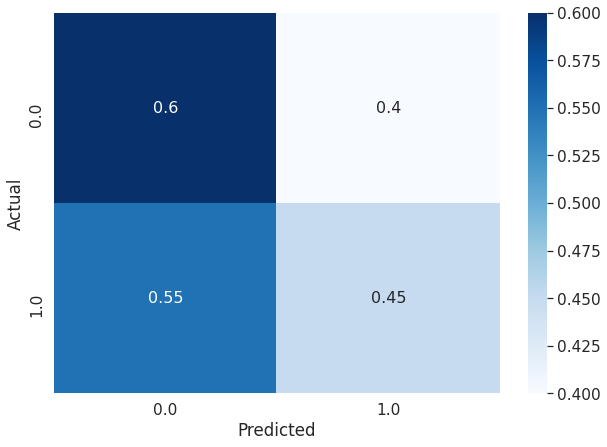

In [25]:
import seaborn as sns
df_cm = pd.DataFrame(matrix_norm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size